In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tr

import torch_geometric
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import Batch

from typing import Optional, Union

from torch import Tensor
from torch.nn import Linear
from torch_geometric.nn.conv import MessagePassing, GravNetConv
from torch_geometric.typing import OptTensor, PairOptTensor, PairTensor
from torch_scatter import scatter

from tqdm.notebook import tqdm

import numpy as np

import json
import math
import os
import time

import sklearn
import sklearn.metrics

import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})

In [2]:
# VICReg loss function
def criterion(x, y, device='cuda', lmbd = 5e-3, u = 1, v= 1, epsilon = 1e-3):
    bs = x.size(0)
    emb = x.size(1)

    std_x = torch.sqrt(x.var(dim=0) + epsilon)
    std_y = torch.sqrt(y.var(dim=0) + epsilon)
    var_loss = torch.mean(F.relu(1 - std_x)) + torch.mean(F.relu(1 - std_y))

    invar_loss = F.mse_loss(x, y)

    xNorm = (x - x.mean(0)) / x.std(0)
    yNorm = (y - y.mean(0)) / y.std(0)
    crossCorMat = (xNorm.T@yNorm) / bs
    cross_loss = (crossCorMat*lmbd - torch.eye(emb, device=torch.device(device))*lmbd).pow(2).sum()

    loss = u*var_loss + v*invar_loss + cross_loss

    return loss

# CLIC

In [21]:
import glob
all_files = glob.glob(f"../data/clic/mix/data_*")

In [22]:
# load the clic dataset
data = []
for f in all_files:
    data += torch.load(f"{f}")

In [110]:
loader = torch_geometric.loader.DataLoader(data, batch_size=1, shuffle=True)
for batch in loader:
    print(f"A single event: \n {batch}")
    break

A single event: 
 Batch(x=[72, 12], ygen=[72, 5], ygen_id=[72], ycand=[72, 5], ycand_id=[72], batch=[72], ptr=[2])


In [111]:
print(f"num of clic events {len(loader)}")

num of clic events 61381


## From event to tracks/clusters

In [84]:
CLUSTERS_X = 6
TRACKS_X = 11
COMMON_X = 11

In [70]:
# function that takes an event~Batch() and splits it into two Batch() objects representing the tracks/clusters
def distinguish_PFelements(batch):
    
    track_id = 1
    cluster_id = 2

    tracks = Batch(x = batch.x[batch.x[:,0]==track_id][:,1:].float(),   # remove the first input feature which is not needed anymore
                  ygen = batch.ygen[batch.x[:,0]==track_id],
                  ygen_id = batch.ygen_id[batch.x[:,0]==track_id],
                  ycand = batch.ycand[batch.x[:,0]==track_id],
                  ycand_id = batch.ycand_id[batch.x[:,0]==track_id],
                  batch = batch.batch[batch.x[:,0]==track_id],
                 )
    clusters = Batch(x = batch.x[batch.x[:,0]==cluster_id][:,1:].float()[:,:CLUSTERS_X],   # remove the first input feature which is not needed anymore
                    ygen = batch.ygen[batch.x[:,0]==cluster_id],
                    ygen_id = batch.ygen_id[batch.x[:,0]==cluster_id],
                    ycand = batch.ycand[batch.x[:,0]==cluster_id],
                    ycand_id = batch.ycand_id[batch.x[:,0]==cluster_id],
                    batch = batch.batch[batch.x[:,0]==cluster_id],                    
                   )
    
    return tracks, clusters

# conversly, function that combines the learned latent representations back into one Batch() object
def combine_PFelements(tracks, clusters):

    # zero padding
    clusters.x = torch.cat([clusters.x, torch.from_numpy(np.zeros([clusters.x.shape[0],TRACKS_X-CLUSTERS_X]))], axis=1)
    
    event = Batch(x = torch.cat([tracks.x, clusters.x]),
                  ygen = torch.cat([tracks.ygen, clusters.ygen]),
                  ygen_id = torch.cat([tracks.ygen_id, clusters.ygen_id]),
                  ycand = torch.cat([tracks.ycand, clusters.ycand]),
                  ycand_id = torch.cat([tracks.ycand_id, clusters.ycand_id]),
                  batch = torch.cat([tracks.batch, clusters.batch]),
                 )
    
    return event

In [71]:
tracks, clusters = distinguish_PFelements(batch)

print(f"event:    {batch}")
print(f"tracks:   {tracks}")
print(f"clusters: {clusters}")

event:    Batch(x=[155, 12], ygen=[155, 5], ygen_id=[155], ycand=[155, 5], ycand_id=[155], batch=[155], ptr=[2])
tracks:   Batch(x=[56, 11], ygen=[56, 5], ygen_id=[56], ycand=[56, 5], ycand_id=[56], batch=[56])
clusters: Batch(x=[99, 6], ygen=[99, 5], ygen_id=[99], ycand=[99, 5], ycand_id=[99], batch=[99])


# VICreg

In [72]:
# define the Encoder that learns latent representations of tracks and clusters 
# these representations will be used by MLPF which is the downstream task
class Encoder(nn.Module):

    def __init__(
        self,
        input_dim=11,
        embedding_dim=34,
        num_convs=2,
    ):
        super(Encoder, self).__init__()

        self.act = nn.ELU

        ### 1. different embedding of tracks/clusters
        self.nn1 = nn.Sequential(
            nn.Linear(TRACKS_X, 126),
            self.act(),
            nn.Linear(126, 126),
            self.act(),
            nn.Linear(126, embedding_dim),
        )
        self.nn2 = nn.Sequential(
            nn.Linear(CLUSTERS_X, 126),
            self.act(),
            nn.Linear(126, 126),
            self.act(),
            nn.Linear(126, embedding_dim),
        )

        ### 2. same GNN for tracks/clusters
        self.conv = nn.ModuleList()
        for i in range(num_convs):
            self.conv.append(GravNetConv(embedding_dim, embedding_dim, 
                                         space_dimensions=4, 
                                         propagate_dimensions=22, 
                                         k=16))
        
    def forward(self, tracks, clusters):
  
        embedding_tracks = self.nn1(tracks.x.float())
        embedding_clusters = self.nn2(clusters.x.float())
        
        # perform a series of graph convolutions
        for num, conv in enumerate(self.conv):
            embedding_tracks = conv(embedding_tracks, tracks.batch)
            embedding_clusters = conv(embedding_clusters, clusters.batch)
        
        return embedding_tracks, embedding_clusters

In [73]:
# define the decoder that expands the latent representations of tracks and clusters 
class Decoder(nn.Module):

    def __init__(
        self,
        embedding_dim=34,
        output_dim=200,
    ):
        super(Decoder, self).__init__()

        self.act = nn.ELU
    
        ############################ DECODER
        self.expander = nn.Sequential(
            nn.Linear(embedding_dim, 126),
            self.act(),
            nn.Linear(126, 126),
            self.act(),
            nn.Linear(126, output_dim),
        )
        
    def forward(self, out_tracks, out_clusters):
        
        return self.expander(out_tracks), self.expander(out_clusters)

In [74]:
# retrieve a batch with batch_size>1
loader = torch_geometric.loader.DataLoader(data, batch_size=2)
for batch in loader:
    break

# retrieve the tracks and clusters
tracks, clusters = distinguish_PFelements(batch)

# setup VICReg
encoder = Encoder(embedding_dim=34)
decoder = Decoder(embedding_dim=34)

# make encoder forward pass
embedding_tracks, embedding_clusters = encoder(tracks, clusters)

# pooling
pooled_tracks = global_mean_pool(embedding_tracks, tracks.batch)     
pooled_clusters = global_mean_pool(embedding_clusters, clusters.batch)

# make decoder forward pass
out_tracks, out_clusters = decoder(pooled_tracks, pooled_clusters)

# compute the loss between the two latent representations
loss = criterion(out_tracks, out_clusters, device='cpu')
print('loss is: ', loss.item())

loss is:  4.2232232093811035


In [75]:
# train the encoder
def train_VICReg(encoder, decoder, data, batch_size, lr, epochs):
    
    data_train = data[:int(0.8*len(data))]
    data_valid = data[int(0.8*len(data)):]

    train_loader = torch_geometric.loader.DataLoader(data_train, batch_size)
    valid_loader = torch_geometric.loader.DataLoader(data_valid, batch_size)    
    
    optimizer = torch.optim.SGD(list(encoder.parameters()) + list(decoder.parameters()), 
                                lr=lr, 
                                momentum= 0.9, 
                                weight_decay=1.5e-4
                               )

    patience = 20
    best_val_loss = 99999.9
    stale_epochs = 0

    losses_train, losses_valid = [], []
    
    for epoch in tqdm(range(epochs)):

        encoder.train()
        decoder.train()
        loss_train = 0
        
        for batch in tqdm(train_loader):
            # make transformation
            tracks, clusters = distinguish_PFelements(batch)

            ### ENCODE
            embedding_tracks, embedding_clusters = encoder(tracks, clusters)
            ### POOLING
            pooled_tracks = global_mean_pool(embedding_tracks, tracks.batch)     
            pooled_clusters = global_mean_pool(embedding_clusters, clusters.batch)
            ### DECODE
            out_tracks, out_clusters = decoder(pooled_tracks, pooled_clusters)

            # compute loss
            loss = criterion(out_tracks, out_clusters, device='cpu')
            
            # update parameters
            for param in encoder.parameters():
                param.grad = None
            for param in decoder.parameters():
                param.grad = None                
            loss.backward()
            optimizer.step()

            loss_train += loss.detach()
        
        encoder.eval()
        decoder.eval()
        loss_valid = 0
        with torch.no_grad():
            for batch in tqdm(valid_loader):
                # make transformation
                tracks, clusters = distinguish_PFelements(batch)

                ### ENCODE
                embedding_tracks, embedding_clusters = encoder(tracks, clusters)
                ### POOLING
                pooled_tracks = global_mean_pool(embedding_tracks, tracks.batch)     
                pooled_clusters = global_mean_pool(embedding_clusters, clusters.batch)
                ### DECODE
                out_tracks, out_clusters = decoder(pooled_tracks, pooled_clusters)

                # compute loss
                loss = criterion(out_tracks, out_clusters, device='cpu')
                
                loss_valid += loss.detach()
                
        print(f"epoch {epoch} - loss_train: {round(loss_train.item(),3)} - loss_valid: {round(loss_valid.item(),3)}")

        losses_train.append(loss_train/len(train_loader)) 
        losses_valid.append(loss_valid/len(valid_loader)) 

    return losses_train, losses_valid

In [76]:
batch_size = 100
lr = 1e-3
encoder = Encoder(embedding_dim=34)
decoder = Decoder(embedding_dim=34)
losses_train_VICRreg, losses_valid_VICRreg = train_VICReg(encoder, decoder, data, batch_size, lr, epochs=100)


epoch 0 - loss_train: 876.686 - loss_valid: 216.646



epoch 1 - loss_train: 839.975 - loss_valid: 209.892



epoch 2 - loss_train: 740.919 - loss_valid: 176.394



epoch 3 - loss_train: 715.614 - loss_valid: 179.448



epoch 4 - loss_train: 686.495 - loss_valid: 169.943



epoch 5 - loss_train: 665.793 - loss_valid: 158.397



epoch 6 - loss_train: 620.973 - loss_valid: 148.97



epoch 7 - loss_train: 606.282 - loss_valid: 158.994



epoch 8 - loss_train: 588.338 - loss_valid: 151.025



epoch 9 - loss_train: 556.926 - loss_valid: 137.537



epoch 10 - loss_train: 547.486 - loss_valid: 142.518



epoch 11 - loss_train: 521.46 - loss_valid: 122.817



epoch 12 - loss_train: 489.124 - loss_valid: 124.354



epoch 13 - loss_train: 480.527 - loss_valid: 120.714



epoch 14 - loss_train: 444.084 - loss_valid: 186.49



epoch 15 - loss_train: 420.524 - loss_valid: 156.365



epoch 16 - loss_train: 403.38 - loss_valid: 146.094



epoch 17 - loss_train: 392.515 - loss_valid: 166.277



epoch 18 - loss_train: 380.971 - loss_valid: 99.409



epoch 19 - loss_train: 374.088 - loss_valid: 92.921



epoch 20 - loss_train: 369.316 - loss_valid: 104.664



epoch 21 - loss_train: 366.641 - loss_valid: 119.638



epoch 22 - loss_train: 362.936 - loss_valid: 115.598



epoch 23 - loss_train: 360.201 - loss_valid: 106.736



epoch 24 - loss_train: 355.774 - loss_valid: 133.775



epoch 25 - loss_train: 352.923 - loss_valid: 112.858



epoch 26 - loss_train: 345.061 - loss_valid: 123.126



epoch 27 - loss_train: 340.69 - loss_valid: 106.408



epoch 28 - loss_train: 334.768 - loss_valid: 117.391



epoch 29 - loss_train: 332.253 - loss_valid: 114.6



epoch 30 - loss_train: 328.391 - loss_valid: 127.841



epoch 31 - loss_train: 408.461 - loss_valid: 125.542



epoch 32 - loss_train: 330.859 - loss_valid: 101.196



epoch 33 - loss_train: 322.605 - loss_valid: 109.709



epoch 34 - loss_train: 314.382 - loss_valid: 78.744



epoch 35 - loss_train: 302.916 - loss_valid: 77.125



epoch 36 - loss_train: 293.787 - loss_valid: 73.627



epoch 37 - loss_train: 288.256 - loss_valid: 72.695



epoch 38 - loss_train: 284.326 - loss_valid: 72.641



epoch 39 - loss_train: 281.771 - loss_valid: 73.426



epoch 40 - loss_train: 279.185 - loss_valid: 72.755



epoch 41 - loss_train: 277.095 - loss_valid: 70.902



epoch 42 - loss_train: 274.416 - loss_valid: 71.384



epoch 43 - loss_train: 272.709 - loss_valid: 70.084



epoch 44 - loss_train: 271.149 - loss_valid: 70.255



epoch 45 - loss_train: 270.061 - loss_valid: 71.399



epoch 46 - loss_train: 268.967 - loss_valid: 69.668



epoch 47 - loss_train: 267.519 - loss_valid: 70.398



epoch 48 - loss_train: 266.855 - loss_valid: 67.847



epoch 49 - loss_train: 265.159 - loss_valid: 67.762



epoch 50 - loss_train: 264.414 - loss_valid: 67.874



epoch 51 - loss_train: 263.79 - loss_valid: 66.399



epoch 52 - loss_train: 262.397 - loss_valid: 66.278



epoch 53 - loss_train: 261.818 - loss_valid: 66.212



epoch 54 - loss_train: 261.204 - loss_valid: 65.963



epoch 55 - loss_train: 260.398 - loss_valid: 65.704



epoch 56 - loss_train: 259.635 - loss_valid: 65.641



epoch 57 - loss_train: 259.225 - loss_valid: 65.536



epoch 58 - loss_train: 258.283 - loss_valid: 65.325



epoch 59 - loss_train: 257.857 - loss_valid: 65.41



epoch 60 - loss_train: 257.098 - loss_valid: 65.472



epoch 61 - loss_train: 257.242 - loss_valid: 66.495



epoch 62 - loss_train: 256.531 - loss_valid: 64.954



epoch 63 - loss_train: 255.719 - loss_valid: 64.844



epoch 64 - loss_train: 254.818 - loss_valid: 64.92



epoch 65 - loss_train: 254.073 - loss_valid: 64.85



epoch 66 - loss_train: 253.152 - loss_valid: 64.814



epoch 67 - loss_train: 252.354 - loss_valid: 64.779



epoch 68 - loss_train: 251.418 - loss_valid: 64.714



epoch 69 - loss_train: 250.944 - loss_valid: 64.773



epoch 70 - loss_train: 249.892 - loss_valid: 64.786



epoch 71 - loss_train: 249.137 - loss_valid: 64.651



epoch 72 - loss_train: 248.437 - loss_valid: 64.873



epoch 73 - loss_train: 247.545 - loss_valid: 64.993



epoch 74 - loss_train: 246.454 - loss_valid: 64.581



epoch 75 - loss_train: 245.419 - loss_valid: 64.366



epoch 76 - loss_train: 244.457 - loss_valid: 64.249



epoch 77 - loss_train: 243.658 - loss_valid: 63.571



epoch 78 - loss_train: 242.44 - loss_valid: 63.164



epoch 79 - loss_train: 241.462 - loss_valid: 62.793



epoch 80 - loss_train: 240.491 - loss_valid: 62.298



epoch 81 - loss_train: 239.436 - loss_valid: 62.006



epoch 82 - loss_train: 238.234 - loss_valid: 61.631



epoch 83 - loss_train: 237.354 - loss_valid: 61.692



epoch 84 - loss_train: 236.412 - loss_valid: 61.42



epoch 85 - loss_train: 235.097 - loss_valid: 61.489



epoch 86 - loss_train: 234.112 - loss_valid: 61.362



epoch 87 - loss_train: 232.992 - loss_valid: 61.11



epoch 88 - loss_train: 232.094 - loss_valid: 61.774



epoch 89 - loss_train: 231.194 - loss_valid: 61.359



epoch 90 - loss_train: 230.137 - loss_valid: 61.582



epoch 91 - loss_train: 229.411 - loss_valid: 60.826



epoch 92 - loss_train: 228.342 - loss_valid: 60.513



epoch 93 - loss_train: 227.206 - loss_valid: 59.988



epoch 94 - loss_train: 226.56 - loss_valid: 59.75



epoch 95 - loss_train: 225.281 - loss_valid: 59.683



epoch 96 - loss_train: 224.325 - loss_valid: 59.537



epoch 97 - loss_train: 223.68 - loss_valid: 59.132



epoch 98 - loss_train: 222.729 - loss_valid: 59.089



epoch 99 - loss_train: 221.78 - loss_valid: 58.803



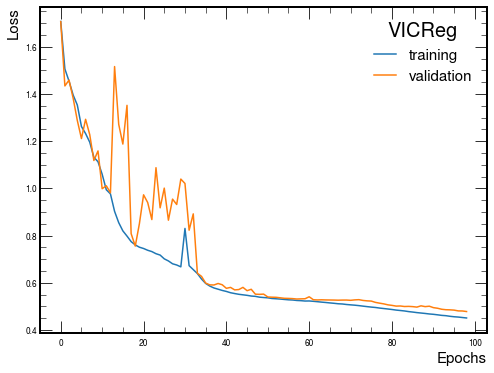

In [77]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(len(losses_train_VICRreg[1:])), losses_train_VICRreg[1:], label="training")
ax.plot(range(len(losses_valid_VICRreg[1:])), losses_valid_VICRreg[1:], label="validation")
ax.set_xlabel("Epochs", fontsize=15)
ax.set_ylabel("Loss", fontsize=15)
ax.legend(title='VICReg', loc="best", title_fontsize=20, fontsize=15);

# Train MLPF

In [85]:
class MLPF(nn.Module):
    def __init__(
        self,
        input_dim=COMMON_X + 34 + 200,
        embedding_dim = 34,
        num_classes=6,
        num_convs=2,
        k=8,
    ):
        super(MLPF, self).__init__()

        self.act = nn.ELU

        # GNN that uses the embeddings learnt by VICReg as the input features
        self.conv = nn.ModuleList()
        for i in range(num_convs):
            self.conv.append(GravNetConv(input_dim, input_dim, 
                                         space_dimensions=4, 
                                         propagate_dimensions=22, 
                                         k=k))

        # DNN that acts on the node level to predict the PID
        self.nn = nn.Sequential(
            nn.Linear(input_dim, 126),
            self.act(),
            nn.Linear(126, 126),
            self.act(),
            nn.Linear(126, num_classes),
        )

    def forward(self, batch):

        # unfold the Batch object
        input_ = batch.x.float()
        batch = batch.batch

#         embedding = self.nn0(input_)
        # perform a series of graph convolutions
        for num, conv in enumerate(self.conv):
            embedding = conv(input_, batch)

        # predict the PIDs
        preds_id = self.nn(embedding)

        return preds_id

In [86]:
def compute_weights(target_ids, num_classes):
    """
    computes necessary weights to accomodate class imbalance in the loss function
    """

    vs, cs = torch.unique(target_ids, return_counts=True)
    weights = torch.zeros(num_classes)
    for k, v in zip(vs, cs):
        weights[k] = 1.0 / math.sqrt(float(v))
    # weights[2] = weights[2] * 3  # emphasize nhadrons
    return weights

def train_mlpf(data, batch_size, model, with_VICReg, epochs):
        
    data_train = data[:4000]
    data_val = data[4000:5000]
    data_test = data[5000:]

    train_loader = torch_geometric.loader.DataLoader(data_train, batch_size)
    val_loader = torch_geometric.loader.DataLoader(data_val, batch_size)
    test_loader = torch_geometric.loader.DataLoader(data_test, batch_size)
    
    lr = 1e-3
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)#, momentum= 0.9, weight_decay=1.5e-4)

    patience = 20
    best_val_loss = 99999.9
    stale_epochs = 0

    losses_train, losses_valid = [], []

    encoder.eval()
    decoder.eval()    

    for epoch in tqdm(range(epochs)):

        model.train()
        loss_train = 0
        for batch in tqdm(train_loader):
            if with_VICReg:
                # make transformation
                tracks, clusters = distinguish_PFelements(batch)

                ### ENCODE
                embedding_tracks, embedding_clusters = encoder(tracks, clusters)
                ### POOLING
                pooled_tracks = global_mean_pool(embedding_tracks, tracks.batch)     
                pooled_clusters = global_mean_pool(embedding_clusters, clusters.batch)
                ### DECODE
                out_tracks, out_clusters = decoder(pooled_tracks, pooled_clusters)
      
                # use the learnt representation as your input as well as the global feature vector
                tracks.x = torch.cat([tracks.x, embedding_tracks, out_tracks[tracks.batch]], axis=1)
                clusters.x = torch.cat([clusters.x, embedding_clusters, out_clusters[clusters.batch]], axis=1)

                event = combine_PFelements(tracks, clusters)

            else:
                event = batch
                
            # make mlpf forward pass
            pred_ids_one_hot = model(event)
            pred_ids = torch.argmax(pred_ids_one_hot, axis=1)
            target_ids = event.ygen_id

            weights = compute_weights(target_ids, num_classes=6)  # to accomodate class imbalance
            loss = torch.nn.functional.cross_entropy(pred_ids_one_hot, target_ids, weight=weights)  # for classifying PID

            # update parameters
            for param in model.parameters():
                param.grad = None
            loss.backward()
            optimizer.step()

            loss_train += loss.detach()


        model.eval()
        loss_valid = 0
        with torch.no_grad():
            for batch in tqdm(val_loader):
                time.time()
                if with_VICReg:            
                    # make transformation
                    tracks, clusters = distinguish_PFelements(batch)

                    ### ENCODE
                    embedding_tracks, embedding_clusters = encoder(tracks, clusters)
                    ### POOLING
                    pooled_tracks = global_mean_pool(embedding_tracks, tracks.batch)     
                    pooled_clusters = global_mean_pool(embedding_clusters, clusters.batch)
                    ### DECODE
                    out_tracks, out_clusters = decoder(pooled_tracks, pooled_clusters)
      
                    # use the learnt representation as your input as well as the global feature vector
                    tracks.x = torch.cat([tracks.x, embedding_tracks, out_tracks[tracks.batch]], axis=1)
                    clusters.x = torch.cat([clusters.x, embedding_clusters, out_clusters[clusters.batch]], axis=1)

                    event = combine_PFelements(tracks, clusters)

                else:
                    event = batch

                # make mlpf forward pass
                pred_ids_one_hot = model(event)
                pred_ids = torch.argmax(pred_ids_one_hot, axis=1)
                target_ids = event.ygen_id

                weights = compute_weights(target_ids, num_classes=6)  # to accomodate class imbalance
                loss = torch.nn.functional.cross_entropy(pred_ids_one_hot, target_ids, weight=weights)  # for classifying PID

                loss_valid += loss.detach()

        print(f"epoch {epoch} - train: {round(loss_train.item(),3)} - valid: {round(loss_valid.item(), 3)} - stale={stale_epochs}")

        losses_train.append(loss_train/len(train_loader)) 
        losses_valid.append(loss_valid/len(val_loader))

        # early-stopping
        if losses_valid[epoch] < best_val_loss:
            best_val_loss = losses_valid[epoch]
            stale_epochs = 0
        else:
            stale_epochs += 1
            
    fig, ax = plt.subplots()
    ax.plot(range(len(losses_train[1:])), losses_train[1:], label="training")
    ax.plot(range(len(losses_valid[1:])), losses_valid[1:], label="validation")
    ax.set_xlabel("Epochs", fontsize=15)
    ax.set_ylabel("Loss", fontsize=15)
    if with_VICReg:
        ax.legend(title='ssl MLPF', loc="best", title_fontsize=20, fontsize=15);
    else:
        ax.legend(title='native MLPF', loc="best", title_fontsize=20, fontsize=15);
    return losses_train, losses_valid

In [89]:
# train ssl version of MLPF
model_ssl = MLPF(COMMON_X + 34 + 200)
print("Num of model paramaters: ", sum(p.numel() for p in model_ssl.parameters() if p.requires_grad))

Num of model paramaters:  202652



epoch 0 - train: 121.018 - valid: 22.65 - stale=0



epoch 1 - train: 83.836 - valid: 20.02 - stale=0



epoch 2 - train: 79.788 - valid: 20.134 - stale=0



epoch 3 - train: 79.105 - valid: 19.497 - stale=1



epoch 4 - train: 77.613 - valid: 19.285 - stale=0



epoch 5 - train: 76.924 - valid: 19.14 - stale=0



epoch 6 - train: 76.42 - valid: 19.028 - stale=0



epoch 7 - train: 76.016 - valid: 18.936 - stale=0



epoch 8 - train: 75.675 - valid: 18.858 - stale=0



epoch 9 - train: 75.379 - valid: 18.79 - stale=0



epoch 10 - train: 75.117 - valid: 18.73 - stale=0



epoch 11 - train: 74.884 - valid: 18.675 - stale=0



epoch 12 - train: 74.673 - valid: 18.626 - stale=0



epoch 13 - train: 74.479 - valid: 18.58 - stale=0



epoch 14 - train: 74.301 - valid: 18.539 - stale=0



epoch 15 - train: 74.137 - valid: 18.501 - stale=0



epoch 16 - train: 73.986 - valid: 18.466 - stale=0



epoch 17 - train: 73.844 - valid: 18.432 - stale=0



epoch 18 - train: 73.712 - valid: 18.401 - stale=0



epoch 19 - train: 73.587 - valid: 18.371 - stale=0



epoch 20 - train: 73.469 - valid: 18.342 - stale=0



epoch 21 - train: 73.358 - valid: 18.316 - stale=0



epoch 22 - train: 73.254 - valid: 18.291 - stale=0



epoch 23 - train: 73.155 - valid: 18.268 - stale=0



epoch 24 - train: 73.059 - valid: 18.246 - stale=0



epoch 25 - train: 72.97 - valid: 18.224 - stale=0



epoch 26 - train: 72.888 - valid: 18.205 - stale=0



epoch 27 - train: 72.811 - valid: 18.186 - stale=0



epoch 28 - train: 72.738 - valid: 18.168 - stale=0



epoch 29 - train: 72.667 - valid: 18.152 - stale=0



epoch 30 - train: 72.599 - valid: 18.136 - stale=0



epoch 31 - train: 72.533 - valid: 18.12 - stale=0



epoch 32 - train: 72.47 - valid: 18.105 - stale=0



epoch 33 - train: 72.409 - valid: 18.091 - stale=0



epoch 34 - train: 72.35 - valid: 18.077 - stale=0



epoch 35 - train: 72.292 - valid: 18.063 - stale=0



epoch 36 - train: 72.236 - valid: 18.05 - stale=0



epoch 37 - train: 72.18 - valid: 18.036 - stale=0



epoch 38 - train: 72.125 - valid: 18.023 - stale=0



epoch 39 - train: 72.07 - valid: 18.01 - stale=0



epoch 40 - train: 72.016 - valid: 17.997 - stale=0



epoch 41 - train: 71.963 - valid: 17.984 - stale=0



epoch 42 - train: 71.911 - valid: 17.972 - stale=0



epoch 43 - train: 71.86 - valid: 17.959 - stale=0



epoch 44 - train: 71.808 - valid: 17.947 - stale=0



epoch 45 - train: 71.756 - valid: 17.934 - stale=0



epoch 46 - train: 71.703 - valid: 17.921 - stale=0



epoch 47 - train: 71.648 - valid: 17.908 - stale=0



epoch 48 - train: 71.587 - valid: 17.894 - stale=0



epoch 49 - train: 71.519 - valid: 17.873 - stale=0



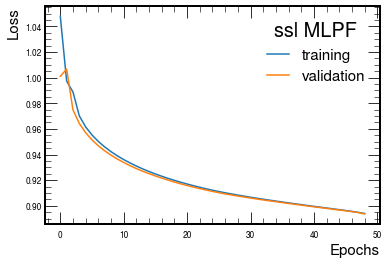

In [90]:
batch_size = 50
losses_train_ssl, losses_valid_ssl = train_mlpf(data, batch_size, model_ssl, with_VICReg=True, epochs=50)

In [91]:
class MLPF_native(nn.Module):
    def __init__(
        self,
        input_dim=8,
        embedding_dim=34,
        num_classes=6,
        num_convs=2,
        k=8,
    ):
        super(MLPF_native, self).__init__()

        self.act = nn.ELU
        
        # embedding
        self.nn0 = nn.Sequential(
            nn.Linear(input_dim, 280),
            self.act(),
            nn.Linear(280, 280),
            self.act(),
            nn.Linear(280, 280),
            self.act(),
            nn.Linear(280, embedding_dim),
        )
        
        # GNN that uses the embeddings learnt by VICReg as the input features
        self.conv = nn.ModuleList()
        for i in range(num_convs):
            self.conv.append(GravNetConv(embedding_dim, embedding_dim, 
                                         space_dimensions=4, 
                                         propagate_dimensions=22, 
                                         k=k))

        # DNN that acts on the node level to predict the PID
        self.nn = nn.Sequential(
            nn.Linear(embedding_dim, 126),
            self.act(),
            nn.Linear(126, 126),
            self.act(),
            nn.Linear(126, num_classes),
        )

    def forward(self, batch):

        # unfold the Batch object
        input_ = batch.x.float()
        batch = batch.batch

        # embedding
        embedding = self.nn0(input_)
        
        # perform a series of graph convolutions
        for num, conv in enumerate(self.conv):
            embedding = conv(embedding, batch)

        # predict the PIDs
        preds_id = self.nn(embedding)

        return preds_id

In [94]:
model_native = MLPF_native(input_dim=COMMON_X+1)
print("Num of model paramaters: ", sum(p.numel() for p in model_native.parameters() if p.requires_grad))

Num of model paramaters:  198920



epoch 0 - train: 115.318 - valid: 26.757 - stale=0



epoch 1 - train: 105.564 - valid: 26.04 - stale=0



epoch 2 - train: 102.991 - valid: 25.417 - stale=0



epoch 3 - train: 100.422 - valid: 24.739 - stale=0



epoch 4 - train: 97.484 - valid: 23.938 - stale=0



epoch 5 - train: 93.966 - valid: 22.98 - stale=0



epoch 6 - train: 89.885 - valid: 21.923 - stale=0



epoch 7 - train: 85.727 - valid: 20.949 - stale=0



epoch 8 - train: 82.304 - valid: 20.248 - stale=0



epoch 9 - train: 80.061 - valid: 19.833 - stale=0



epoch 10 - train: 78.776 - valid: 19.6 - stale=0



epoch 11 - train: 78.018 - valid: 19.453 - stale=0



epoch 12 - train: 77.505 - valid: 19.345 - stale=0



epoch 13 - train: 77.108 - valid: 19.256 - stale=0



epoch 14 - train: 76.777 - valid: 19.178 - stale=0



epoch 15 - train: 76.494 - valid: 19.107 - stale=0



epoch 16 - train: 76.256 - valid: 19.045 - stale=0



epoch 17 - train: 76.079 - valid: 18.998 - stale=0



epoch 18 - train: 75.975 - valid: 18.97 - stale=0



epoch 19 - train: 75.871 - valid: 18.934 - stale=0



epoch 20 - train: 75.731 - valid: 18.894 - stale=0



epoch 21 - train: 75.588 - valid: 18.856 - stale=0



epoch 22 - train: 75.456 - valid: 18.822 - stale=0



epoch 23 - train: 75.328 - valid: 18.789 - stale=0



epoch 24 - train: 75.207 - valid: 18.757 - stale=0



epoch 25 - train: 75.087 - valid: 18.728 - stale=0



epoch 26 - train: 74.973 - valid: 18.699 - stale=0



epoch 27 - train: 74.862 - valid: 18.671 - stale=0



epoch 28 - train: 74.752 - valid: 18.644 - stale=0



epoch 29 - train: 74.648 - valid: 18.618 - stale=0



epoch 30 - train: 74.547 - valid: 18.594 - stale=0



epoch 31 - train: 74.449 - valid: 18.57 - stale=0



epoch 32 - train: 74.354 - valid: 18.546 - stale=0



epoch 33 - train: 74.262 - valid: 18.524 - stale=0



epoch 34 - train: 74.172 - valid: 18.501 - stale=0



epoch 35 - train: 74.085 - valid: 18.48 - stale=0



epoch 36 - train: 73.998 - valid: 18.458 - stale=0



epoch 37 - train: 73.915 - valid: 18.437 - stale=0



epoch 38 - train: 73.831 - valid: 18.416 - stale=0



epoch 39 - train: 73.749 - valid: 18.395 - stale=0



epoch 40 - train: 73.661 - valid: 18.374 - stale=0



epoch 41 - train: 73.575 - valid: 18.353 - stale=0



epoch 42 - train: 73.489 - valid: 18.333 - stale=0



epoch 43 - train: 73.405 - valid: 18.313 - stale=0



epoch 44 - train: 73.324 - valid: 18.293 - stale=0



epoch 45 - train: 73.241 - valid: 18.273 - stale=0



epoch 46 - train: 73.16 - valid: 18.254 - stale=0



epoch 47 - train: 73.081 - valid: 18.235 - stale=0



epoch 48 - train: 73.002 - valid: 18.216 - stale=0



epoch 49 - train: 72.922 - valid: 18.198 - stale=0



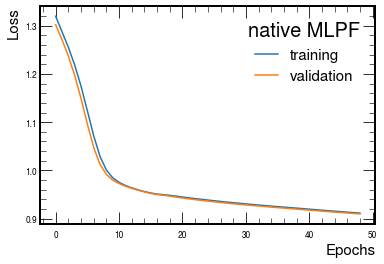

In [95]:
# train native MLPF
batch_size = 50
losses_train_native, losses_valid_native = train_mlpf(data, batch_size, model_native, with_VICReg=False, epochs=50)

## Compare native vs SSL

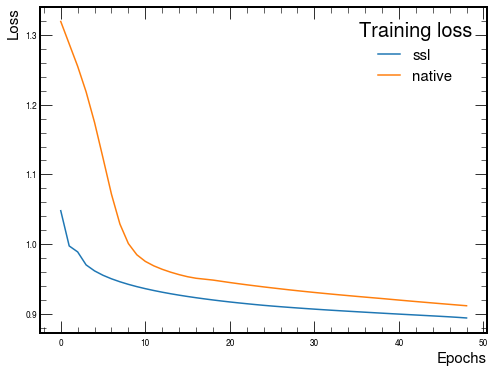

In [96]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(len(losses_train_ssl[1:])), losses_train_ssl[1:], label="ssl")
ax.plot(range(len(losses_train_native[1:])), losses_train_native[1:], label="native")
ax.set_xlabel("Epochs", fontsize=15)
ax.set_ylabel("Loss", fontsize=15)
ax.legend(title='Training loss', loc="best", title_fontsize=20, fontsize=15);

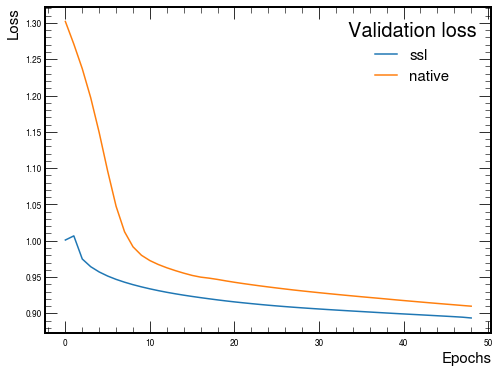

In [97]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(len(losses_valid_ssl[1:])), losses_valid_ssl[1:], label="ssl")
ax.plot(range(len(losses_valid_native[1:])), losses_valid_native[1:], label="native")
ax.set_xlabel("Epochs", fontsize=15)
ax.set_ylabel("Loss", fontsize=15)
ax.legend(title='Validation loss', loc="best", title_fontsize=20, fontsize=15);

## Evaluate the SSL against native MLPF

In [98]:
def evaluate_mlpf(model, with_VICReg):
    num_classes = 6
    conf_matrix = np.zeros((num_classes, num_classes))

    model.eval()
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        t = time.time()
        for i, batch in tqdm(enumerate(test_loader)):
            if with_VICReg:
                 # make transformation
                tracks, clusters = distinguish_PFelements(batch)

                ### ENCODE
                embedding_tracks, embedding_clusters = encoder(tracks, clusters)
                ### POOLING
                pooled_tracks = global_mean_pool(embedding_tracks, tracks.batch)     
                pooled_clusters = global_mean_pool(embedding_clusters, clusters.batch)
                ### DECODE
                out_tracks, out_clusters = decoder(pooled_tracks, pooled_clusters)
      
                # use the learnt representation as your input as well as the global feature vector
                tracks.x = torch.cat([tracks.x, embedding_tracks, out_tracks[tracks.batch]], axis=1)
                clusters.x = torch.cat([clusters.x, embedding_clusters, out_clusters[clusters.batch]], axis=1)

                event = combine_PFelements(tracks, clusters)

            else:
                event = batch

            # make mlpf forward pass
            pred_ids_one_hot = model(event)
            pred_ids = torch.argmax(pred_ids_one_hot, axis=1)
            target_ids = event.ygen_id

            conf_matrix += sklearn.metrics.confusion_matrix(
                target_ids.detach().cpu(), pred_ids.detach().cpu(), labels=range(num_classes)
            )
        print(f"Time taken is {round(time.time() - t,2)}s")
    return conf_matrix

CLASS_NAMES_CLIC_LATEX = ["none", "chhad", "nhad", "$\gamma$", "$e^\pm$", "$\mu^\pm$"]

def plot_conf_matrix(cm, title):
    import itertools

    cmap = plt.get_cmap("Blues")
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    cm[np.isnan(cm)] = 0.0

    fig = plt.figure(figsize=(8, 6))

    ax = plt.axes()
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()

    thresh = cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            "{:0.2f}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black", fontsize=15
        )
    plt.title(title, fontsize=25)
    plt.xlabel("Predicted label", fontsize=15)
    plt.ylabel("True label", fontsize=15)

    plt.xticks(range(len(CLASS_NAMES_CLIC_LATEX)), CLASS_NAMES_CLIC_LATEX, rotation=45, fontsize=15)
    plt.yticks(range(len(CLASS_NAMES_CLIC_LATEX)), CLASS_NAMES_CLIC_LATEX, fontsize=15)

    plt.tight_layout()

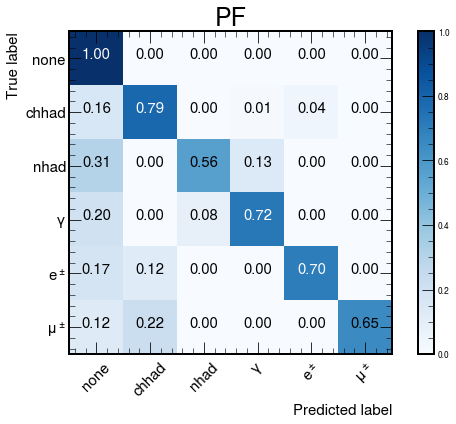

In [99]:
# make confusion matrix of PF for comparison
batch_size = 50

num_classes = 6
conf_matrix_pf = np.zeros((num_classes, num_classes))

test_loader = torch_geometric.loader.DataLoader(data[5000:], batch_size)   
for i, batch in tqdm(enumerate(test_loader)):

    # make mlpf forward pass
    target_ids = batch.ygen_id
    pred_ids = batch.ycand_id
    
    conf_matrix_pf += sklearn.metrics.confusion_matrix(
        target_ids.detach().cpu(), pred_ids.detach().cpu(), labels=range(num_classes)
    )
plot_conf_matrix(conf_matrix_pf, 'PF')


Time taken is 162.26s


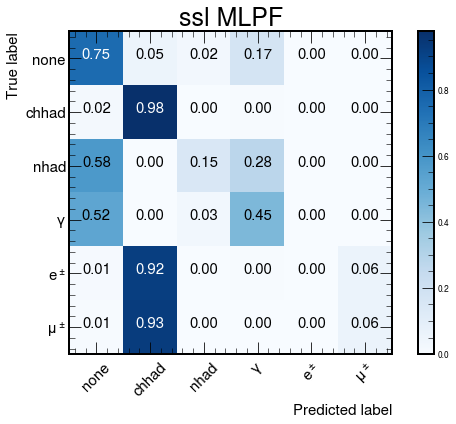

In [100]:
batch_size = 100
conf_matrix_ssl = evaluate_mlpf(model_ssl, with_VICReg=True)
plot_conf_matrix(conf_matrix_ssl, 'ssl MLPF')


Time taken is 100.82s


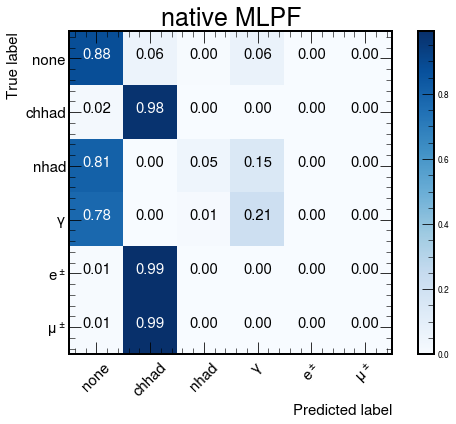

In [101]:
conf_matrix = evaluate_mlpf(model_native, with_VICReg=False)
plot_conf_matrix(conf_matrix, 'native MLPF')

In [107]:
print("Num of ssl mlpf model paramaters: ", sum(p.numel() for p in model_ssl.parameters() if p.requires_grad))

Num of ssl mlpf model paramaters:  202652


In [108]:
print("Num of native mlpf model paramaters: ", sum(p.numel() for p in model_native.parameters() if p.requires_grad))

Num of native mlpf model paramaters:  198920
